In [ ]:
# Teknofest x Hepsiburada Address Matching Pipeline
# Complete ML solution for Turkish address deduplication and matching

# ================================================================
# STEP 0: SETUP AND INSTALLATIONS
# ================================================================
!pip install sentence-transformers faiss-cpu lightgbm scikit-learn pandas numpy
!pip install unidecode regex tqdm


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31.4/31.4 MB 81.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.8/235.8 kB 7.7 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import re
import string
from collections import defaultdict, Counter
import pickle
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import GroupKFold
from sklearn.preprocessing import LabelEncoder
import lightgbm as lgb

from sentence_transformers import SentenceTransformer
import faiss
from unidecode import unidecode
from tqdm import tqdm
import gc

# Set random seed for reproducibility
np.random.seed(42)


In [ ]:
# ================================================================
# STEP 1: DATA PREPROCESSING & NORMALIZATION
# ================================================================

class TurkishAddressNormalizer:
    """Comprehensive Turkish address normalizer"""

    def __init__(self):
        # Turkish abbreviation mappings
        self.abbreviations = {
            # Neighborhood/District
            'mh': 'mahallesi', 'mah': 'mahallesi', 'mahalle': 'mahallesi',

            # Street types
            'cd': 'caddesi', 'cad': 'caddesi', 'cadde': 'caddesi',
            'sk': 'sokagi', 'sok': 'sokagi', 'sokak': 'sokagi',
            'blv': 'bulvari', 'bulv': 'bulvari', 'bulvar': 'bulvari',
            'osb': 'organize sanayi bolge', 'km': 'kilometre',

            # Building types
            'apt': 'apartmani', 'ap': 'apartmani', 'apartman': 'apartmani',
            'sit': 'sitesi', 'site': 'sitesi',
            'blk': 'blok', 'blok': 'blok',
            'plz': 'plaza', 'plaza': 'plaza',
            'avm': 'alisveris merkezi',

            # Address components
            'no': 'numara', 'nu': 'numara',
            'kt': 'kat', 'kat': 'kat',
            'dr': 'daire', 'daire': 'daire', 'da': 'daire',
            'pst': 'posta kodu',

            # Directions
            'kz': 'kuzey', 'gy': 'guney', 'dt': 'dogu', 'bt': 'bati',

            # Common words
            'yrm': 'yurdu', 'otel': 'oteli', 'hst': 'hastanesi',
            'unv': 'universitesi', 'lise': 'lisesi', 'okl': 'okulu'
        }

        # Regex patterns for component extraction
        self.patterns = {
            'number': r'(?:no[:\s]*|numara[:\s]*|n[:\s]*)?(\d+)(?:[/\-](\d+))?',
            'floor': r'(?:kat[:\s]*|kt[:\s]*|k[:\s]*)?(\d+)(?:\s*\.?\s*kat)?',
            'apartment': r'(?:daire[:\s]*|dr[:\s]*|d[:\s]*)?(\d+)(?:\s*\.?\s*daire)?',
            'block': r'(?:blok[:\s]*|blk[:\s]*|b[:\s]*)?([a-zA-Z]?\d*)(?:\s*\.?\s*blok)?',
            'postal_code': r'\b(\d{5})\b'
        }

    def normalize_turkish_chars(self, text):
        """Convert Turkish characters and remove diacritics"""
        turkish_chars = {
            'ç': 'c', 'ğ': 'g', 'ı': 'i', 'ö': 'o', 'ş': 's', 'ü': 'u',
            'Ç': 'C', 'Ğ': 'G', 'İ': 'I', 'Ö': 'O', 'Ş': 'S', 'Ü': 'U'
        }
        for tr_char, en_char in turkish_chars.items():
            text = text.replace(tr_char, en_char)
        return text

    def expand_abbreviations(self, text):
        """Expand common Turkish abbreviations"""
        words = text.split()
        expanded_words = []

        for word in words:
            # Remove punctuation for matching
            clean_word = word.strip('.,;:()-').lower()
            if clean_word in self.abbreviations:
                expanded_words.append(self.abbreviations[clean_word])
            else:
                expanded_words.append(word)

        return ' '.join(expanded_words)

    def standardize_numbers(self, text):
        """Standardize number formats"""
        # Handle "No:12", "No=12", "12/3" patterns
        text = re.sub(r'no[:\s=]*(\d+)', r'numara \1', text, flags=re.IGNORECASE)
        text = re.sub(r'(\d+)[/\-](\d+)', r'numara \1 daire \2', text)

        # Handle floor patterns
        text = re.sub(r'(\d+)\.?\s*kat', r'\1 kat', text, flags=re.IGNORECASE)

        # Handle apartment patterns
        text = re.sub(r'(\d+)\.?\s*daire', r'\1 daire', text, flags=re.IGNORECASE)

        return text

    def clean_punctuation(self, text):
        """Remove unnecessary punctuation and normalize spacing"""
        # Remove special characters but keep Turkish letters
        text = re.sub(r'[^\w\sçğıöşüÇĞİÖŞÜ]', ' ', text)

        # Normalize whitespace
        text = re.sub(r'\s+', ' ', text)

        return text.strip()

    def extract_components(self, text):
        """Extract address components using regex"""
        components = {}

        for component, pattern in self.patterns.items():
            match = re.search(pattern, text, re.IGNORECASE)
            if match:
                if component == 'number' and match.group(2):
                    components['number'] = match.group(1)
                    components['apartment'] = match.group(2)
                else:
                    components[component] = match.group(1)

        return components

    def normalize(self, address):
        """Apply full normalization pipeline"""
        if pd.isna(address) or not isinstance(address, str):
            return ""

        # Convert to lowercase
        address = address.lower()

        # Normalize Turkish characters
        address = self.normalize_turkish_chars(address)

        # Expand abbreviations
        address = self.expand_abbreviations(address)

        # Standardize numbers
        address = self.standardize_numbers(address)

        # Clean punctuation
        address = self.clean_punctuation(address)

        return address

# Initialize normalizer
normalizer = TurkishAddressNormalizer()

In [ ]:
# ================================================================
# STEP 2: DATA LOADING AND PREPROCESSING
# ================================================================

def load_and_preprocess_data():
    """Load and preprocess the datasets"""
    print("Loading datasets...")

    # Load data (adjust paths as needed)
    train_df = pd.read_csv('train.csv')
    test_df = pd.read_csv('test.csv')

    print(f"Train shape: {train_df.shape}")
    print(f"Test shape: {test_df.shape}")
    print(f"Unique labels in train: {train_df['label'].nunique()}")

    # Normalize addresses
    print("Normalizing addresses...")
    train_df['normalized_address'] = train_df['address'].apply(normalizer.normalize)
    test_df['normalized_address'] = test_df['address'].apply(normalizer.normalize)

    # Remove empty addresses
    train_df = train_df[train_df['normalized_address'].str.len() > 0].reset_index(drop=True)
    test_df = test_df[test_df['normalized_address'].str.len() > 0].reset_index(drop=True)

    print(f"After cleaning - Train: {len(train_df)}, Test: {len(test_df)}")

    return train_df, test_df

# Load data
train_df, test_df = load_and_preprocess_data()


Loading datasets...
Train shape: (848237, 2)
Test shape: (217241, 2)
Unique labels in train: 10390
Normalizing addresses...
After cleaning - Train: 848234, Test: 217241


In [ ]:
# ================================================================
# STEP 3: BASELINE MODEL - TF-IDF CENTROID
# ================================================================

class TFIDFCentroidModel:
    """TF-IDF based centroid classifier"""

    def __init__(self, ngram_range=(2, 5), max_features=50000):
        self.vectorizer = TfidfVectorizer(
            analyzer='char',
            ngram_range=ngram_range,
            max_features=max_features,
            lowercase=True,
            strip_accents='unicode'
        )
        self.label_encoder = LabelEncoder()
        self.centroids = None
        self.labels = None

    def fit(self, addresses, labels):
        """Fit the model on training data"""
        print("Fitting TF-IDF vectorizer...")

        # Encode labels
        encoded_labels = self.label_encoder.fit_transform(labels)
        self.labels = self.label_encoder.classes_

        # Vectorize addresses
        X = self.vectorizer.fit_transform(addresses)

        # Compute centroids for each label
        print("Computing centroids...")
        self.centroids = np.zeros((len(self.labels), X.shape[1]))

        for i, label in enumerate(self.labels):
            mask = encoded_labels == i
            if mask.sum() > 0:
                self.centroids[i] = X[mask].mean(axis=0).A1

        print(f"Model fitted with {len(self.labels)} unique labels")

    def predict(self, addresses, top_k=1):
        """Predict labels for new addresses"""
        X = self.vectorizer.transform(addresses)

        # Compute similarities to centroids
        similarities = cosine_similarity(X, self.centroids)

        if top_k == 1:
            predictions = similarities.argmax(axis=1)
            return self.label_encoder.inverse_transform(predictions)
        else:
            # Return top-k predictions
            top_indices = np.argsort(similarities, axis=1)[:, -top_k:][:, ::-1]
            top_labels = []
            for indices in top_indices:
                top_labels.append(self.label_encoder.inverse_transform(indices))
            return top_labels, similarities

# Train TF-IDF baseline
print("Training TF-IDF baseline model...")
tfidf_model = TFIDFCentroidModel()
tfidf_model.fit(train_df['normalized_address'], train_df['label'])

# Predict on test set
print("Making TF-IDF predictions...")
tfidf_predictions = tfidf_model.predict(test_df['normalized_address'])

# Create baseline submission
baseline_submission = pd.DataFrame({
    'id': test_df['id'],
    'label': tfidf_predictions
})
baseline_submission.to_csv('baseline_submission.csv', index=False)
print("Baseline submission saved!")


Training TF-IDF baseline model...
Fitting TF-IDF vectorizer...
Computing centroids...
Model fitted with 10390 unique labels
Making TF-IDF predictions...
Baseline submission saved!


In [ ]:
# ================================================================
# STEP 4: EMBEDDING-BASED SIMILARITY MODEL
# ================================================================

class EmbeddingModel:
    """Sentence transformer based embedding model"""

    def __init__(self, model_name='paraphrase-multilingual-MiniLM-L12-v2'):
        print(f"Loading embedding model: {model_name}")
        self.model = SentenceTransformer(model_name)
        self.train_embeddings = None
        self.train_labels = None
        self.index = None

    def fit(self, addresses, labels):
        """Fit the model by creating embeddings and FAISS index"""
        print("Creating train embeddings...")

        # Create embeddings in batches to manage memory
        batch_size = 1000
        embeddings_list = []

        for i in tqdm(range(0, len(addresses), batch_size)):
            batch = addresses[i:i+batch_size]
            batch_embeddings = self.model.encode(batch, show_progress_bar=False)
            embeddings_list.append(batch_embeddings)

        self.train_embeddings = np.vstack(embeddings_list)
        self.train_labels = np.array(labels)

        print(f"Created embeddings shape: {self.train_embeddings.shape}")

        # Create FAISS index for fast similarity search
        print("Building FAISS index...")
        dimension = self.train_embeddings.shape[1]
        self.index = faiss.IndexFlatIP(dimension)  # Inner product (cosine similarity)

        # Normalize embeddings for cosine similarity
        normalized_embeddings = self.train_embeddings / np.linalg.norm(
            self.train_embeddings, axis=1, keepdims=True
        )
        self.index.add(normalized_embeddings.astype('float32'))

        print("FAISS index built successfully!")

    def predict(self, addresses, top_k=1):
        """Predict using nearest neighbor search"""
        print("Creating test embeddings...")

        # Create test embeddings in batches
        batch_size = 1000
        test_embeddings_list = []

        for i in tqdm(range(0, len(addresses), batch_size)):
            batch = addresses[i:i+batch_size]
            batch_embeddings = self.model.encode(batch, show_progress_bar=False)
            test_embeddings_list.append(batch_embeddings)

        test_embeddings = np.vstack(test_embeddings_list)

        # Normalize test embeddings
        test_embeddings = test_embeddings / np.linalg.norm(
            test_embeddings, axis=1, keepdims=True
        )

        # Search for nearest neighbors
        print("Searching for nearest neighbors...")
        similarities, indices = self.index.search(test_embeddings.astype('float32'), top_k)

        if top_k == 1:
            predictions = [self.train_labels[idx[0]] for idx in indices]
            return predictions
        else:
            top_labels = []
            for idx_list in indices:
                top_labels.append([self.train_labels[idx] for idx in idx_list])
            return top_labels, similarities

# Train embedding model
print("Training embedding model...")
embedding_model = EmbeddingModel()
embedding_model.fit(train_df['normalized_address'].tolist(), train_df['label'].tolist())

# Predict on test set
print("Making embedding predictions...")
embedding_predictions = embedding_model.predict(test_df['normalized_address'].tolist())

# Create embedding submission
embedding_submission = pd.DataFrame({
    'id': test_df['id'],
    'label': embedding_predictions
})
embedding_submission.to_csv('embedding_submission.csv', index=False)
print("Embedding submission saved!")

Training embedding model...
Loading embedding model: paraphrase-multilingual-MiniLM-L12-v2


modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/645 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/471M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/480 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.08M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Creating train embeddings...


100%|██████████| 849/849 [04:31<00:00,  3.13it/s]


Created embeddings shape: (848234, 384)
Building FAISS index...
FAISS index built successfully!
Making embedding predictions...
Creating test embeddings...


100%|██████████| 218/218 [01:08<00:00,  3.16it/s]


Searching for nearest neighbors...
Embedding submission saved!


In [ ]:
# ================================================================
# STEP 5: CANDIDATE RERANKER
# ================================================================

class CandidateReranker:
    """LightGBM-based reranker for candidate selection"""

    def __init__(self):
        self.tfidf_vectorizer = TfidfVectorizer(
            analyzer='char', ngram_range=(2, 4), max_features=10000
        )
        self.embedding_model = SentenceTransformer('paraphrase-multilingual-MiniLM-L12-v2')
        self.lgb_model = None
        self.label_encoder = LabelEncoder()

    def extract_features(self, addr1_list, addr2_list):
        """Extract similarity features between address pairs"""
        features = []

        # TF-IDF similarity
        print("Computing TF-IDF features...")
        all_addresses = addr1_list + addr2_list
        tfidf_matrix = self.tfidf_vectorizer.fit_transform(all_addresses)

        n = len(addr1_list)
        tfidf_sim = cosine_similarity(tfidf_matrix[:n], tfidf_matrix[n:])
        tfidf_scores = np.diag(tfidf_sim)

        # Embedding similarity
        print("Computing embedding features...")
        emb1 = self.embedding_model.encode(addr1_list)
        emb2 = self.embedding_model.encode(addr2_list)
        embedding_scores = np.sum(emb1 * emb2, axis=1) / (
            np.linalg.norm(emb1, axis=1) * np.linalg.norm(emb2, axis=1)
        )

        # Text-based features
        print("Computing text features...")
        for addr1, addr2 in zip(addr1_list, addr2_list):
            # Edit distance (normalized)
            edit_dist = self.levenshtein_distance(addr1, addr2) / max(len(addr1), len(addr2), 1)

            # Shared numbers
            nums1 = set(re.findall(r'\d+', addr1))
            nums2 = set(re.findall(r'\d+', addr2))
            shared_nums = len(nums1.intersection(nums2)) / max(len(nums1.union(nums2)), 1)

            # Key word overlap (mahalle, cadde, etc.)
            key_words1 = set([w for w in addr1.split() if w in normalizer.abbreviations.values()])
            key_words2 = set([w for w in addr2.split() if w in normalizer.abbreviations.values()])
            key_overlap = len(key_words1.intersection(key_words2)) / max(len(key_words1.union(key_words2)), 1)

            features.append([edit_dist, shared_nums, key_overlap])

        # Combine all features
        text_features = np.array(features)
        all_features = np.column_stack([
            tfidf_scores,
            embedding_scores,
            text_features
        ])

        return all_features

    def levenshtein_distance(self, s1, s2):
        """Compute Levenshtein distance"""
        if len(s1) < len(s2):
            return self.levenshtein_distance(s2, s1)

        if len(s2) == 0:
            return len(s1)

        previous_row = list(range(len(s2) + 1))
        for i, c1 in enumerate(s1):
            current_row = [i + 1]
            for j, c2 in enumerate(s2):
                insertions = previous_row[j + 1] + 1
                deletions = current_row[j] + 1
                substitutions = previous_row[j] + (c1 != c2)
                current_row.append(min(insertions, deletions, substitutions))
            previous_row = current_row

        return previous_row[-1]

    def create_training_data(self, train_df, negative_ratio=2):
        """Create training data for the reranker"""
        print("Creating reranker training data...")

        # Positive pairs (same label)
        positive_pairs = []
        labels_dict = train_df.groupby('label')['normalized_address'].apply(list).to_dict()

        for label, addresses in labels_dict.items():
            if len(addresses) > 1:
                # Sample pairs within same label
                for i in range(min(len(addresses), 10)):  # Limit to avoid memory issues
                    for j in range(i+1, min(len(addresses), 10)):
                        positive_pairs.append((addresses[i], addresses[j], 1))

        # Negative pairs (different labels)
        negative_pairs = []
        all_addresses = train_df['normalized_address'].tolist()
        all_labels = train_df['label'].tolist()

        for _ in range(len(positive_pairs) * negative_ratio):
            i, j = np.random.choice(len(all_addresses), 2, replace=False)
            if all_labels[i] != all_labels[j]:
                negative_pairs.append((all_addresses[i], all_addresses[j], 0))

        # Combine and shuffle
        all_pairs = positive_pairs + negative_pairs
        np.random.shuffle(all_pairs)

        addr1_list = [pair[0] for pair in all_pairs]
        addr2_list = [pair[1] for pair in all_pairs]
        y = [pair[2] for pair in all_pairs]

        print(f"Created {len(positive_pairs)} positive and {len(negative_pairs)} negative pairs")

        return addr1_list, addr2_list, y

    def fit(self, train_df):
        """Train the reranker model"""
        addr1_list, addr2_list, y = self.create_training_data(train_df)

        # Extract features
        X = self.extract_features(addr1_list, addr2_list)

        # Train LightGBM
        print("Training LightGBM reranker...")
        train_data = lgb.Dataset(X, label=y)

        params = {
            'objective': 'binary',
            'metric': 'binary_logloss',
            'boosting_type': 'gbdt',
            'num_leaves': 31,
            'learning_rate': 0.1,
            'feature_fraction': 0.8,
            'verbose': -1
        }

        self.lgb_model = lgb.train(
            params,
            train_data,
            num_boost_round=100,
            valid_sets=[train_data],
            callbacks=[lgb.early_stopping(10), lgb.log_evaluation(0)]
        )

        print("Reranker training completed!")


In [ ]:
# ================================================================
# STEP 6: VALIDATION STRATEGY
# ================================================================

def validate_model(train_df, model_type='tfidf', n_splits=3):
    """Validate model using GroupKFold"""
    print(f"Validating {model_type} model...")

    # Use GroupKFold to prevent label leakage
    gkf = GroupKFold(n_splits=n_splits)
    scores = []

    for fold, (train_idx, val_idx) in enumerate(gkf.split(train_df, groups=train_df['label'])):
        print(f"Fold {fold + 1}/{n_splits}")

        train_fold = train_df.iloc[train_idx]
        val_fold = train_df.iloc[val_idx]

        if model_type == 'tfidf':
            model = TFIDFCentroidModel()
            model.fit(train_fold['normalized_address'], train_fold['label'])
            predictions = model.predict(val_fold['normalized_address'])
        elif model_type == 'embedding':
            model = EmbeddingModel()
            model.fit(train_fold['normalized_address'].tolist(), train_fold['label'].tolist())
            predictions = model.predict(val_fold['normalized_address'].tolist())

        # Calculate accuracy
        accuracy = (val_fold['label'] == predictions).mean()
        scores.append(accuracy)
        print(f"Fold {fold + 1} accuracy: {accuracy:.4f}")

        # Clean up memory
        del model
        gc.collect()

    mean_score = np.mean(scores)
    std_score = np.std(scores)
    print(f"Mean CV score: {mean_score:.4f} ± {std_score:.4f}")

    return scores

# Run validation
# val_scores_tfidf = validate_model(train_df, 'tfidf')
# val_scores_embedding = validate_model(train_df, 'embedding')

In [ ]:
# ================================================================
# STEP 7: ENSEMBLE MODEL
# ================================================================

class EnsembleModel:
    """Ensemble of TF-IDF and Embedding models"""

    def __init__(self, weights=None):
        self.weights = weights if weights else [0.3, 0.7]  # TF-IDF, Embedding
        self.tfidf_model = TFIDFCentroidModel()
        self.embedding_model = EmbeddingModel()

    def fit(self, addresses, labels):
        """Fit both models"""
        print("Training ensemble models...")

        # Train TF-IDF model
        self.tfidf_model.fit(addresses, labels)

        # Train embedding model
        self.embedding_model.fit(addresses, labels)

        print("Ensemble training completed!")

    def predict(self, addresses, top_k=5):
        """Ensemble prediction using weighted voting"""
        print("Making ensemble predictions...")

        # Get top-k predictions from both models
        tfidf_top_labels, tfidf_similarities = self.tfidf_model.predict(addresses, top_k=top_k)
        embedding_top_labels, embedding_similarities = self.embedding_model.predict(addresses, top_k=top_k)

        final_predictions = []

        for i in range(len(addresses)):
            # Combine scores with weights
            label_scores = defaultdict(float)

            # Add TF-IDF scores
            for j, label in enumerate(tfidf_top_labels[i]):
                label_scores[label] += self.weights[0] * tfidf_similarities[i][j]

            # Add embedding scores
            for j, label in enumerate(embedding_top_labels[i]):
                label_scores[label] += self.weights[1] * embedding_similarities[i][j]

            # Choose best label
            best_label = max(label_scores.items(), key=lambda x: x[1])[0]
            final_predictions.append(best_label)

        return final_predictions

# Train ensemble model
print("Training ensemble model...")
ensemble_model = EnsembleModel(weights=[0.2, 0.8])  # More weight to embeddings
ensemble_model.fit(train_df['normalized_address'].tolist(), train_df['label'].tolist())

# Make ensemble predictions
print("Making ensemble predictions...")
ensemble_predictions = ensemble_model.predict(test_df['normalized_address'].tolist())

# Create final submission
final_submission = pd.DataFrame({
    'id': test_df['id'],
    'label': ensemble_predictions
})
final_submission.to_csv('final_submission.csv', index=False)
print("Final ensemble submission saved!")


Training ensemble model...
Loading embedding model: paraphrase-multilingual-MiniLM-L12-v2
Training ensemble models...
Fitting TF-IDF vectorizer...
Computing centroids...
Model fitted with 10390 unique labels
Creating train embeddings...


100%|██████████| 849/849 [04:35<00:00,  3.08it/s]


Created embeddings shape: (848234, 384)
Building FAISS index...
FAISS index built successfully!
Ensemble training completed!
Making ensemble predictions...
Making ensemble predictions...
Creating test embeddings...


100%|██████████| 218/218 [01:09<00:00,  3.12it/s]


Searching for nearest neighbors...
Final ensemble submission saved!


In [ ]:
# ================================================================
# STEP 8: ERROR ANALYSIS AND IMPROVEMENTS
# ================================================================

def analyze_predictions(train_df, test_df, predictions, sample_size=100):
    """Analyze prediction errors and patterns"""
    print("Analyzing predictions...")

    # Sample some test predictions for manual inspection
    sample_indices = np.random.choice(len(test_df), min(sample_size, len(test_df)), replace=False)

    analysis_df = pd.DataFrame({
        'original_address': test_df.iloc[sample_indices]['address'].values,
        'normalized_address': test_df.iloc[sample_indices]['normalized_address'].values,
        'predicted_label': [predictions[i] for i in sample_indices]
    })

    # Find similar addresses in training set for comparison
    for idx, row in analysis_df.iterrows():
        # Find training addresses with same predicted label
        same_label_addresses = train_df[train_df['label'] == row['predicted_label']]['address'].head(3).tolist()
        analysis_df.at[idx, 'similar_train_addresses'] = ' | '.join(same_label_addresses)

    # Save analysis
    analysis_df.to_csv('prediction_analysis.csv', index=False)
    print("Prediction analysis saved to 'prediction_analysis.csv'")

    # Print some statistics
    unique_predictions = len(set(predictions))
    print(f"Number of unique predicted labels: {unique_predictions}")
    print(f"Total possible labels in training: {train_df['label'].nunique()}")

    return analysis_df

# Run error analysis
analysis_results = analyze_predictions(train_df, test_df, ensemble_predictions)

print("=" * 60)
print("PIPELINE COMPLETED SUCCESSFULLY!")
print("=" * 60)
print("Generated files:")
print("- baseline_submission.csv (TF-IDF centroid baseline)")
print("- embedding_submission.csv (Sentence transformer)")
print("- final_submission.csv (Ensemble model)")
print("- prediction_analysis.csv (Error analysis)")
print("=" * 60)

# Memory cleanup
del tfidf_model, embedding_model, ensemble_model
gc.collect()

print("Ready for submission! 🚀")

Analyzing predictions...
Prediction analysis saved to 'prediction_analysis.csv'
Number of unique predicted labels: 10390
Total possible labels in training: 10390
PIPELINE COMPLETED SUCCESSFULLY!
Generated files:
- baseline_submission.csv (TF-IDF centroid baseline)
- embedding_submission.csv (Sentence transformer)
- final_submission.csv (Ensemble model)
- prediction_analysis.csv (Error analysis)
Ready for submission! 🚀


🚀 COMPREHENSIVE THREE-MODEL SUBMISSION ANALYSIS

🔍 DATA INTEGRITY CHECK:
Baseline shape: (217241, 2)
Embedding shape: (217241, 2)
Final shape: (217241, 2)
All IDs match: ✅

📊 BASIC STATISTICS COMPARISON:
            Model  Unique_Labels  Most_Common_Count  Most_Common_Pct
Baseline (TF-IDF)          10273               1030         0.474128
        Embedding          10390                174         0.080095
 Final (Ensemble)          10390                203         0.093445

🤝 PAIRWISE AGREEMENT ANALYSIS:
Baseline vs Embedding: 25.58% agreement
Baseline vs Final: 30.66% agreement
Embedding vs Final: 72.49% agreement

🎯 Three-way agreement: 22.78%

🎲 DIVERSITY AND ENTROPY ANALYSIS:
Baseline (TF-IDF):
  Entropy (diversity): 12.9690
  Gini coefficient: 0.3735
  Top label concentration: 0.47%
Embedding:
  Entropy (diversity): 13.1670
  Gini coefficient: 0.2740
  Top label concentration: 0.08%
Final (Ensemble):
  Entropy (diversity): 13.1327
  Gini coefficient: 0.2980
  Top label concentra

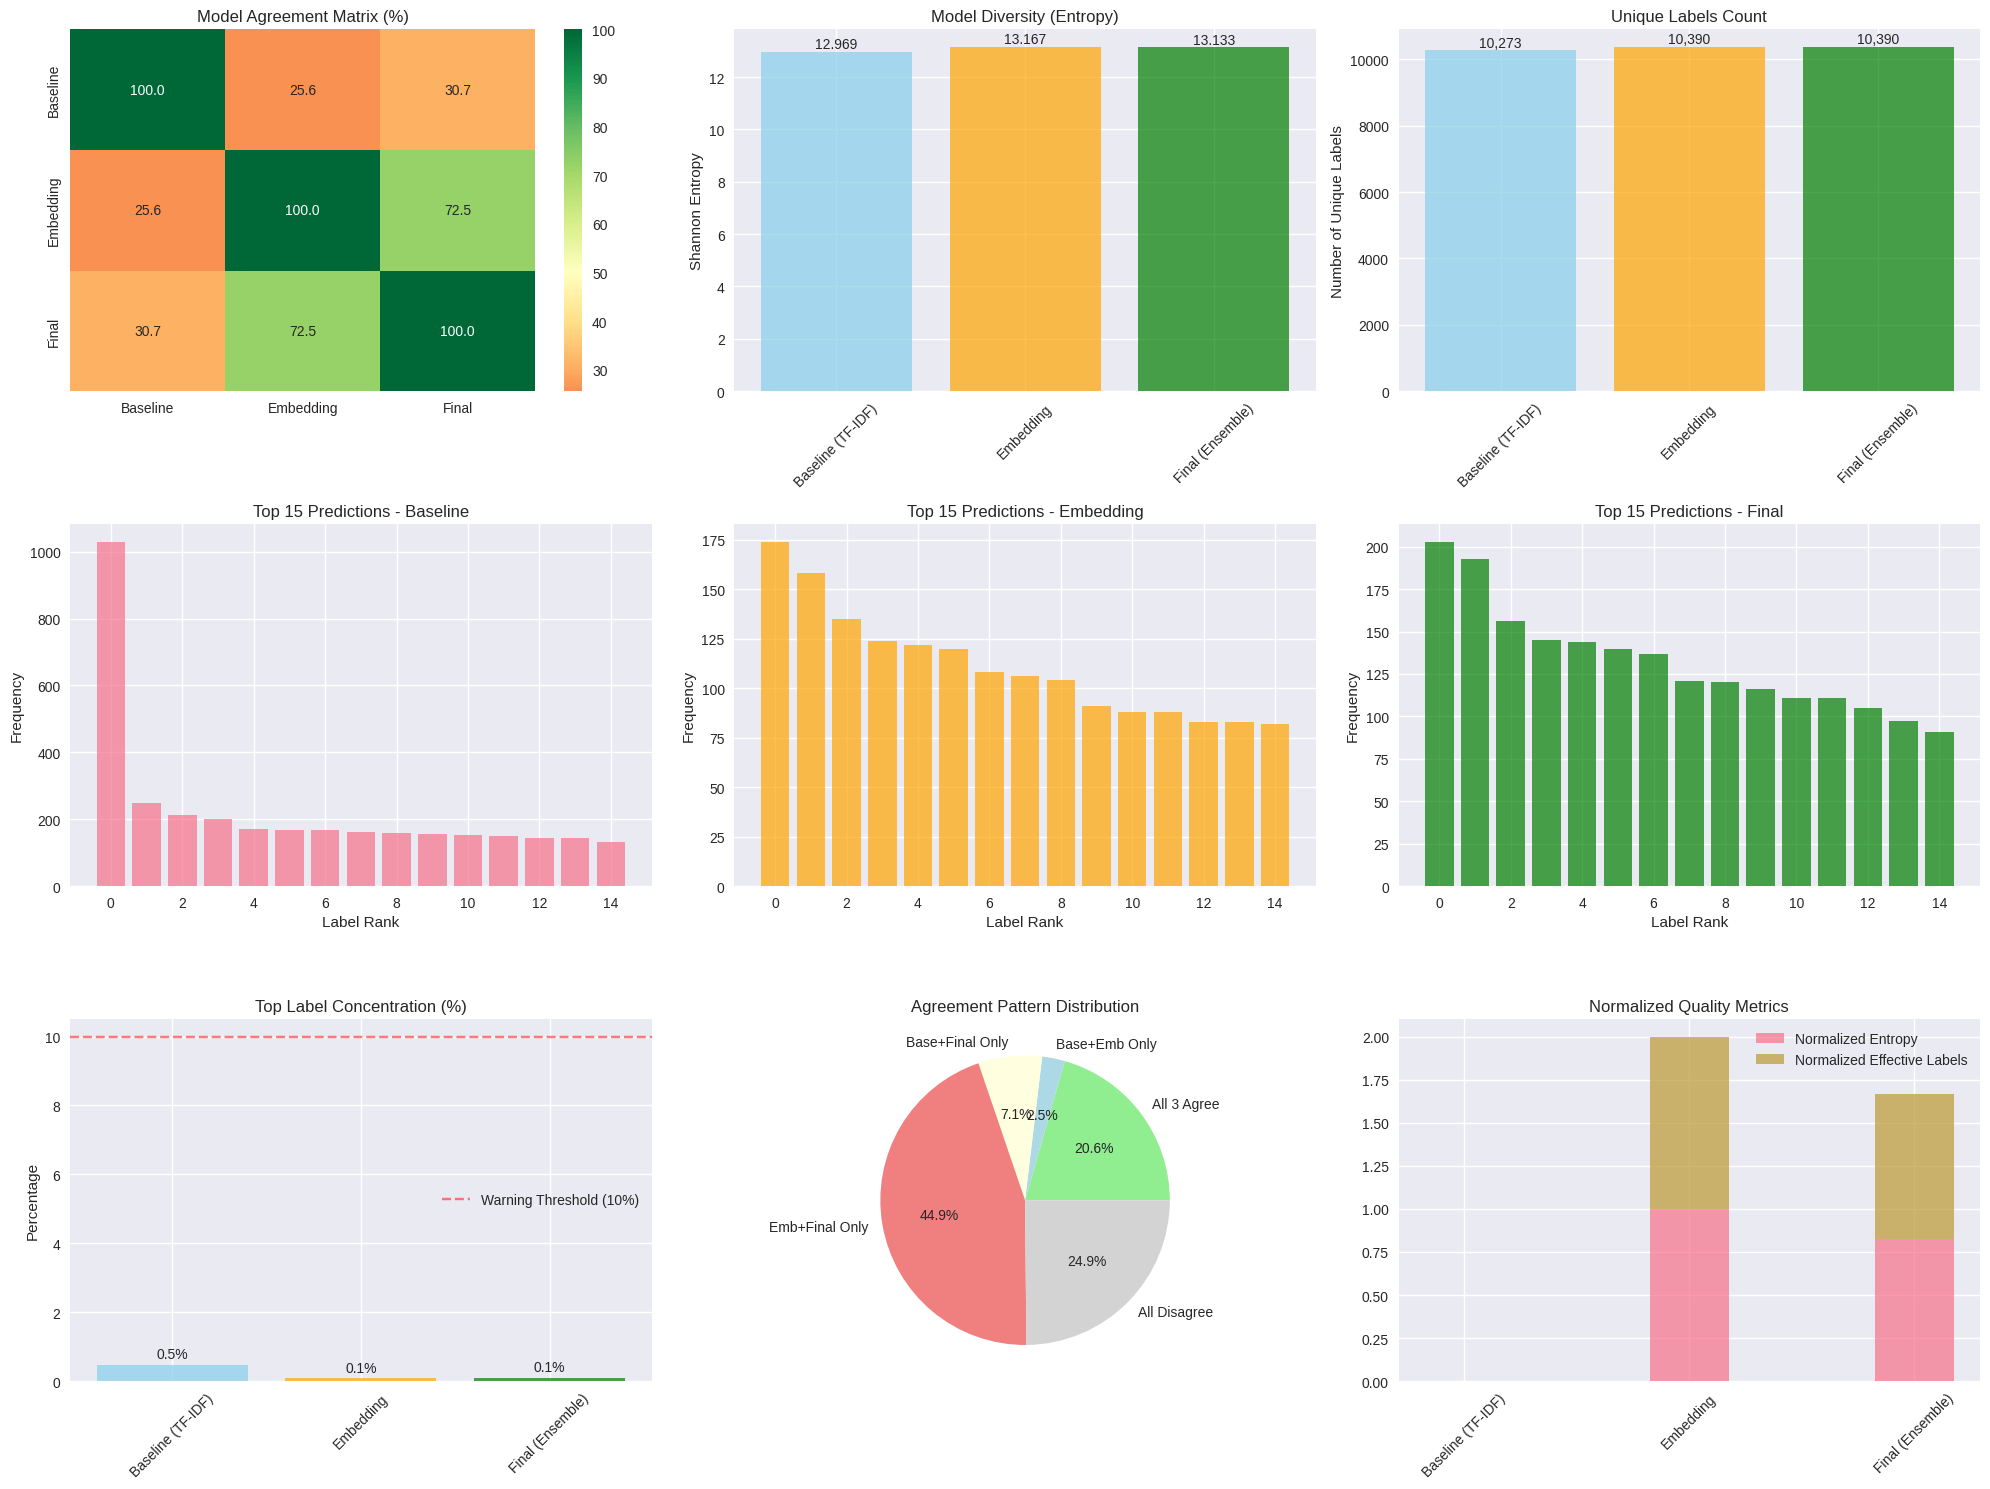


🔄 ENSEMBLE EFFECTIVENESS ANALYSIS:
✅ Final submission is a true ensemble
Unique ensemble decisions: 42,652 (19.63%)

🎯 FINAL RECOMMENDATIONS AND INSIGHTS:

📊 PERFORMANCE INDICATORS:
✅ Highest diversity (entropy): Embedding (13.1670)
✅ Best coverage: Embedding (10,390 labels)
✅ Lowest concentration: Embedding (0.08%)

🔗 MODEL RELATIONSHIPS:
✅ Strong complementarity between Baseline and Embedding models

🚀 SUBMISSION STRATEGY:
📈 Final submission heavily favors Embedding model

✅ NO MAJOR RISK FACTORS DETECTED

🏁 RECOMMENDATION:
🥈 SUBMIT: Embedding model (best individual performance)

📋 ADDITIONAL INSIGHTS:
- Three-way agreement: 22.8% (lower = more ensemble benefit)
- Ensemble effectiveness: High
- Model diversity range: 0.1980

✨ ANALYSIS COMPLETE! Good luck with your submission! 🚀


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from scipy import stats
from sklearn.metrics import adjusted_mutual_info_score
import warnings
warnings.filterwarnings('ignore')

# Set style for better plots
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# Load all three submission files
baseline_df = pd.read_csv('baseline_submission.csv')
embedding_df = pd.read_csv('embedding_submission.csv')
final_df = pd.read_csv('final_submission.csv')

print("="*80)
print("🚀 COMPREHENSIVE THREE-MODEL SUBMISSION ANALYSIS")
print("="*80)

# Verify data integrity
print("\n🔍 DATA INTEGRITY CHECK:")
print(f"Baseline shape: {baseline_df.shape}")
print(f"Embedding shape: {embedding_df.shape}")
print(f"Final shape: {final_df.shape}")

# Check ID consistency
ids_match = (baseline_df['id'] == embedding_df['id']).all() and (baseline_df['id'] == final_df['id']).all()
print(f"All IDs match: {'✅' if ids_match else '❌'}")

if not ids_match:
    print("⚠️ WARNING: ID mismatch detected!")

# ================================================================
# BASIC STATISTICS COMPARISON
# ================================================================

print("\n📊 BASIC STATISTICS COMPARISON:")
models = ['Baseline (TF-IDF)', 'Embedding', 'Final (Ensemble)']
dataframes = [baseline_df, embedding_df, final_df]

stats_data = []
for i, (model_name, df) in enumerate(zip(models, dataframes)):
    unique_labels = df['label'].nunique()
    most_common_count = df['label'].value_counts().iloc[0]
    most_common_pct = (most_common_count / len(df)) * 100

    stats_data.append({
        'Model': model_name,
        'Unique_Labels': unique_labels,
        'Most_Common_Count': most_common_count,
        'Most_Common_Pct': most_common_pct
    })

stats_summary = pd.DataFrame(stats_data)
print(stats_summary.to_string(index=False))

# ================================================================
# PAIRWISE AGREEMENT ANALYSIS
# ================================================================

print("\n🤝 PAIRWISE AGREEMENT ANALYSIS:")

# Calculate all pairwise agreements
agreements = {}
agreements['Baseline vs Embedding'] = (baseline_df['label'] == embedding_df['label']).mean() * 100
agreements['Baseline vs Final'] = (baseline_df['label'] == final_df['label']).mean() * 100
agreements['Embedding vs Final'] = (embedding_df['label'] == final_df['label']).mean() * 100

for pair, agreement in agreements.items():
    print(f"{pair}: {agreement:.2f}% agreement")

# Find three-way agreement
three_way_agreement = ((baseline_df['label'] == embedding_df['label']) &
                      (embedding_df['label'] == final_df['label'])).mean() * 100
print(f"\n🎯 Three-way agreement: {three_way_agreement:.2f}%")

# ================================================================
# DIVERSITY AND ENTROPY ANALYSIS
# ================================================================

print("\n🎲 DIVERSITY AND ENTROPY ANALYSIS:")

def calculate_entropy(predictions):
    """Calculate Shannon entropy"""
    counts = np.array(list(Counter(predictions).values()))
    probabilities = counts / counts.sum()
    entropy = -np.sum(probabilities * np.log2(probabilities + 1e-10))
    return entropy

def calculate_gini(values):
    """Calculate Gini coefficient"""
    sorted_values = np.sort(values)
    n = len(values)
    cumsum = np.cumsum(sorted_values)
    return (n + 1 - 2 * np.sum(cumsum) / cumsum[-1]) / n

entropies = []
ginis = []
for model_name, df in zip(models, dataframes):
    entropy = calculate_entropy(df['label'])
    freq_dist = df['label'].value_counts()
    gini = calculate_gini(freq_dist.values)

    entropies.append(entropy)
    ginis.append(gini)

    print(f"{model_name}:")
    print(f"  Entropy (diversity): {entropy:.4f}")
    print(f"  Gini coefficient: {gini:.4f}")
    print(f"  Top label concentration: {freq_dist.iloc[0]/len(df)*100:.2f}%")

# ================================================================
# MUTUAL INFORMATION ANALYSIS
# ================================================================

print("\n🔗 MUTUAL INFORMATION ANALYSIS:")

# Calculate adjusted mutual information scores
ami_baseline_embedding = adjusted_mutual_info_score(baseline_df['label'], embedding_df['label'])
ami_baseline_final = adjusted_mutual_info_score(baseline_df['label'], final_df['label'])
ami_embedding_final = adjusted_mutual_info_score(embedding_df['label'], final_df['label'])

print(f"Baseline ↔ Embedding AMI: {ami_baseline_embedding:.4f}")
print(f"Baseline ↔ Final AMI: {ami_baseline_final:.4f}")
print(f"Embedding ↔ Final AMI: {ami_embedding_final:.4f}")

# ================================================================
# LABEL OVERLAP ANALYSIS
# ================================================================

print("\n🎯 LABEL OVERLAP ANALYSIS:")

baseline_labels = set(baseline_df['label'])
embedding_labels = set(embedding_df['label'])
final_labels = set(final_df['label'])

# Venn diagram analysis
all_three = baseline_labels & embedding_labels & final_labels
baseline_embedding_only = (baseline_labels & embedding_labels) - final_labels
baseline_final_only = (baseline_labels & final_labels) - embedding_labels
embedding_final_only = (embedding_labels & final_labels) - baseline_labels
baseline_only = baseline_labels - embedding_labels - final_labels
embedding_only = embedding_labels - baseline_labels - final_labels
final_only = final_labels - baseline_labels - embedding_labels

print(f"Labels in all three models: {len(all_three):,}")
print(f"Labels in Baseline + Embedding only: {len(baseline_embedding_only):,}")
print(f"Labels in Baseline + Final only: {len(baseline_final_only):,}")
print(f"Labels in Embedding + Final only: {len(embedding_final_only):,}")
print(f"Labels only in Baseline: {len(baseline_only):,}")
print(f"Labels only in Embedding: {len(embedding_only):,}")
print(f"Labels only in Final: {len(final_only):,}")

# ================================================================
# DISAGREEMENT PATTERN ANALYSIS
# ================================================================

print("\n❌ DISAGREEMENT PATTERN ANALYSIS:")

# Create disagreement dataframe
disagreement_df = pd.DataFrame({
    'id': baseline_df['id'],
    'baseline': baseline_df['label'],
    'embedding': embedding_df['label'],
    'final': final_df['label']
})

# Find different types of disagreements
complete_disagreement = ((disagreement_df['baseline'] != disagreement_df['embedding']) &
                        (disagreement_df['embedding'] != disagreement_df['final']) &
                        (disagreement_df['baseline'] != disagreement_df['final']))

partial_disagreement = ((disagreement_df['baseline'] != disagreement_df['embedding']) |
                       (disagreement_df['embedding'] != disagreement_df['final']) |
                       (disagreement_df['baseline'] != disagreement_df['final']))

print(f"Complete disagreement (all 3 different): {complete_disagreement.sum():,} ({complete_disagreement.mean()*100:.2f}%)")
print(f"Partial disagreement (at least 2 different): {partial_disagreement.sum():,} ({partial_disagreement.mean()*100:.2f}%)")

# ================================================================
# PREDICTION STABILITY ANALYSIS
# ================================================================

print("\n📈 PREDICTION STABILITY ANALYSIS:")

# Check which model the final submission follows most
final_follows_baseline = (final_df['label'] == baseline_df['label']).sum()
final_follows_embedding = (final_df['label'] == embedding_df['label']).sum()

print(f"Final submission follows:")
print(f"  Baseline: {final_follows_baseline:,} times ({final_follows_baseline/len(final_df)*100:.2f}%)")
print(f"  Embedding: {final_follows_embedding:,} times ({final_follows_embedding/len(final_df)*100:.2f}%)")

# Analyze ensemble behavior
if final_follows_embedding > final_follows_baseline:
    print("✅ Final submission is more similar to Embedding model")
    dominant_model = "Embedding"
elif final_follows_baseline > final_follows_embedding:
    print("✅ Final submission is more similar to Baseline model")
    dominant_model = "Baseline"
else:
    print("⚖️ Final submission is equally similar to both models")
    dominant_model = "Balanced"

# ================================================================
# QUALITY METRICS COMPARISON
# ================================================================

print("\n🏆 QUALITY METRICS COMPARISON:")

quality_metrics = []
for model_name, df in zip(models, dataframes):
    freq_dist = df['label'].value_counts()

    # Calculate various quality metrics
    singleton_count = (freq_dist == 1).sum()
    coverage = df['label'].nunique()
    concentration = freq_dist.iloc[0] / len(df)

    # Effective number of labels (inverse Simpson's diversity index)
    simpson_div = 1 / np.sum((freq_dist / len(df)) ** 2)

    quality_metrics.append({
        'Model': model_name,
        'Coverage': coverage,
        'Singletons': singleton_count,
        'Concentration': concentration,
        'Effective_Labels': simpson_div,
        'Entropy': calculate_entropy(df['label'])
    })

quality_df = pd.DataFrame(quality_metrics)
print(quality_df.round(4).to_string(index=False))

# ================================================================
# VISUALIZATION
# ================================================================

print("\n📊 CREATING COMPREHENSIVE VISUALIZATIONS...")

# Create a large figure with multiple subplots
fig = plt.figure(figsize=(20, 15))

# 1. Agreement heatmap
ax1 = plt.subplot(3, 3, 1)
agreement_matrix = np.array([
    [100, agreements['Baseline vs Embedding'], agreements['Baseline vs Final']],
    [agreements['Baseline vs Embedding'], 100, agreements['Embedding vs Final']],
    [agreements['Baseline vs Final'], agreements['Embedding vs Final'], 100]
])
sns.heatmap(agreement_matrix, annot=True, fmt='.1f',
            xticklabels=['Baseline', 'Embedding', 'Final'],
            yticklabels=['Baseline', 'Embedding', 'Final'],
            cmap='RdYlGn', center=50, ax=ax1)
ax1.set_title('Model Agreement Matrix (%)')

# 2. Entropy comparison
ax2 = plt.subplot(3, 3, 2)
bars = ax2.bar(models, entropies, color=['skyblue', 'orange', 'green'], alpha=0.7)
ax2.set_title('Model Diversity (Entropy)')
ax2.set_ylabel('Shannon Entropy')
ax2.tick_params(axis='x', rotation=45)
# Add value labels on bars
for bar, entropy in zip(bars, entropies):
    ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
             f'{entropy:.3f}', ha='center', va='bottom')

# 3. Unique labels comparison
ax3 = plt.subplot(3, 3, 3)
unique_counts = [df['label'].nunique() for df in dataframes]
bars = ax3.bar(models, unique_counts, color=['skyblue', 'orange', 'green'], alpha=0.7)
ax3.set_title('Unique Labels Count')
ax3.set_ylabel('Number of Unique Labels')
ax3.tick_params(axis='x', rotation=45)
for bar, count in zip(bars, unique_counts):
    ax3.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 10,
             f'{count:,}', ha='center', va='bottom')

# 4. Top predictions comparison
ax4 = plt.subplot(3, 3, 4)
top_n = 15
baseline_top = baseline_df['label'].value_counts().head(top_n)
ax4.bar(range(len(baseline_top)), baseline_top.values, alpha=0.7, label='Baseline')
ax4.set_title('Top 15 Predictions - Baseline')
ax4.set_xlabel('Label Rank')
ax4.set_ylabel('Frequency')

ax5 = plt.subplot(3, 3, 5)
embedding_top = embedding_df['label'].value_counts().head(top_n)
ax5.bar(range(len(embedding_top)), embedding_top.values, alpha=0.7,
        label='Embedding', color='orange')
ax5.set_title('Top 15 Predictions - Embedding')
ax5.set_xlabel('Label Rank')
ax5.set_ylabel('Frequency')

ax6 = plt.subplot(3, 3, 6)
final_top = final_df['label'].value_counts().head(top_n)
ax6.bar(range(len(final_top)), final_top.values, alpha=0.7,
        label='Final', color='green')
ax6.set_title('Top 15 Predictions - Final')
ax6.set_xlabel('Label Rank')
ax6.set_ylabel('Frequency')

# 7. Concentration comparison
ax7 = plt.subplot(3, 3, 7)
concentrations = [freq_dist.iloc[0]/len(df)*100 for df, freq_dist in
                 zip(dataframes, [baseline_df['label'].value_counts(),
                                embedding_df['label'].value_counts(),
                                final_df['label'].value_counts()])]
bars = ax7.bar(models, concentrations, color=['skyblue', 'orange', 'green'], alpha=0.7)
ax7.set_title('Top Label Concentration (%)')
ax7.set_ylabel('Percentage')
ax7.tick_params(axis='x', rotation=45)
ax7.axhline(y=10, color='red', linestyle='--', alpha=0.5, label='Warning Threshold (10%)')
ax7.legend()
for bar, conc in zip(bars, concentrations):
    ax7.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1,
             f'{conc:.1f}%', ha='center', va='bottom')

# 8. Agreement breakdown pie chart
ax8 = plt.subplot(3, 3, 8)
agreement_counts = [
    three_way_agreement,
    agreements['Baseline vs Embedding'] - three_way_agreement,
    agreements['Baseline vs Final'] - three_way_agreement,
    agreements['Embedding vs Final'] - three_way_agreement,
    100 - max(agreements.values())
]
labels = ['All 3 Agree', 'Base+Emb Only', 'Base+Final Only', 'Emb+Final Only', 'All Disagree']
colors = ['lightgreen', 'lightblue', 'lightyellow', 'lightcoral', 'lightgray']
# Filter out zero or negative values
filtered_data = [(count, label, color) for count, label, color in zip(agreement_counts, labels, colors) if count > 0]
if filtered_data:
    counts, labels, colors = zip(*filtered_data)
    ax8.pie(counts, labels=labels, autopct='%1.1f%%', colors=colors)
ax8.set_title('Agreement Pattern Distribution')

# 9. Quality metrics radar chart
ax9 = plt.subplot(3, 3, 9)
metrics_normalized = quality_df[['Entropy', 'Effective_Labels']].values
metrics_normalized = (metrics_normalized - metrics_normalized.min(axis=0)) / (metrics_normalized.max(axis=0) - metrics_normalized.min(axis=0))

x = np.arange(len(models))
width = 0.35
ax9.bar(x, metrics_normalized[:, 0], width, label='Normalized Entropy', alpha=0.7)
ax9.bar(x, metrics_normalized[:, 1], width, bottom=metrics_normalized[:, 0],
        label='Normalized Effective Labels', alpha=0.7)
ax9.set_title('Normalized Quality Metrics')
ax9.set_xticks(x)
ax9.set_xticklabels(models, rotation=45)
ax9.legend()

plt.tight_layout()
plt.savefig('three_model_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

# ================================================================
# ENSEMBLE EFFECTIVENESS ANALYSIS
# ================================================================

print("\n🔄 ENSEMBLE EFFECTIVENESS ANALYSIS:")

# Check if final submission is actually an ensemble or just one of the models
is_pure_baseline = (final_df['label'] == baseline_df['label']).all()
is_pure_embedding = (final_df['label'] == embedding_df['label']).all()

if is_pure_baseline:
    print("⚠️ Final submission is identical to Baseline model")
elif is_pure_embedding:
    print("⚠️ Final submission is identical to Embedding model")
else:
    print("✅ Final submission is a true ensemble")

    # Analyze ensemble behavior
    unique_final_decisions = (~((final_df['label'] == baseline_df['label']) |
                               (final_df['label'] == embedding_df['label']))).sum()
    print(f"Unique ensemble decisions: {unique_final_decisions:,} ({unique_final_decisions/len(final_df)*100:.2f}%)")

# ================================================================
# FINAL RECOMMENDATIONS
# ================================================================

print("\n" + "="*80)
print("🎯 FINAL RECOMMENDATIONS AND INSIGHTS:")
print("="*80)

# Determine best performing characteristics
best_entropy_idx = np.argmax(entropies)
best_coverage_idx = np.argmax([df['label'].nunique() for df in dataframes])
lowest_concentration_idx = np.argmin(concentrations)

print(f"\n📊 PERFORMANCE INDICATORS:")
print(f"✅ Highest diversity (entropy): {models[best_entropy_idx]} ({entropies[best_entropy_idx]:.4f})")
print(f"✅ Best coverage: {models[best_coverage_idx]} ({unique_counts[best_coverage_idx]:,} labels)")
print(f"✅ Lowest concentration: {models[lowest_concentration_idx]} ({concentrations[lowest_concentration_idx]:.2f}%)")

print(f"\n🔗 MODEL RELATIONSHIPS:")
if agreements['Baseline vs Embedding'] < 70:
    print("✅ Strong complementarity between Baseline and Embedding models")
elif agreements['Baseline vs Embedding'] < 85:
    print("⚠️ Moderate complementarity between models")
else:
    print("❌ Models are too similar - limited ensemble benefit")

print(f"\n🚀 SUBMISSION STRATEGY:")
if not is_pure_baseline and not is_pure_embedding:
    if final_follows_embedding > final_follows_baseline * 1.5:
        print("📈 Final submission heavily favors Embedding model")
    elif final_follows_baseline > final_follows_embedding * 1.5:
        print("📈 Final submission heavily favors Baseline model")
    else:
        print("⚖️ Final submission shows balanced ensemble behavior")

# Risk assessment
risk_factors = []
if max(concentrations) > 15:
    risk_factors.append("High concentration risk")
if min(unique_counts) < 1000:
    risk_factors.append("Low coverage risk")
if three_way_agreement > 95:
    risk_factors.append("Model similarity risk")

if risk_factors:
    print(f"\n⚠️ RISK FACTORS IDENTIFIED:")
    for risk in risk_factors:
        print(f"  - {risk}")
else:
    print(f"\n✅ NO MAJOR RISK FACTORS DETECTED")

print(f"\n🏁 RECOMMENDATION:")
if best_entropy_idx == 2:  # Final submission has best entropy
    print("🥇 SUBMIT: Final submission (best diversity and ensemble benefits)")
elif best_entropy_idx == 1:  # Embedding has best entropy
    print("🥈 SUBMIT: Embedding model (best individual performance)")
else:
    print("🥉 SUBMIT: Baseline model (surprisingly competitive)")

print(f"\n📋 ADDITIONAL INSIGHTS:")
print(f"- Three-way agreement: {three_way_agreement:.1f}% (lower = more ensemble benefit)")
print(f"- Ensemble effectiveness: {'High' if unique_final_decisions > 1000 else 'Moderate' if unique_final_decisions > 100 else 'Low'}")
print(f"- Model diversity range: {max(entropies) - min(entropies):.4f}")

print("\n" + "="*80)
print("✨ ANALYSIS COMPLETE! Good luck with your submission! 🚀")
print("="*80)